In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import catboost as catb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
TRAIN_DATASET_PATH = './course_project/train.csv'
TEST_DATASET_PATH = './course_project/test.csv'
SUBMISSION_PATH = './course_project/sample_submission.csv'

TARGET = 'Credit Default';

In [3]:
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df = pd.read_csv(TRAIN_DATASET_PATH)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [4]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


# Воспомогательный функционал

### Метод для подготовки данных дата фрейма

In [6]:
def data_preparation(source_df):
    df = source_df.copy()
    
    df['Purpose'] = np.where((df['Purpose'] == 'debt consolidation') 
                               | (df['Purpose'] == 'other')
                               | (df['Purpose'] == 'home improvements'), df['Purpose'], 'other');
    
    df['Years in current job'].fillna(df['Years in current job'].value_counts().index[0], inplace = True)

    for column in ['Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']:
        df[column].fillna(df[column].mean(), inplace = True);
    
    df['Current Loan Amount'] = np.where(df['Current Loan Amount'] == 99999999.0, df['Current Loan Amount'].mean(), df['Current Loan Amount']);

    return df

### Формирование новых признаков

In [7]:
def generate_feature_engineering(source_df):
    df = source_df.copy()
    
    df['monthly_income'] = df['Annual Income'] / 12;

    df['ration_loan_income'] = df['Monthly Debt'] / df['monthly_income'];

    df['ration_loan_income'] = df['Monthly Debt'] / df['monthly_income'];

    years_in_current_job_dict = {'< 1 year': 1, '1 year': 1, '2 years': 1, '3 years': 1,
                                 '4 years': 2, '5 years': 2, '6 years': 2, '7 years': 2,
                                 '8 years': 3, '9 years': 3, '10+ years': 3}

    df['years_in_curr_job'] = df['Years in current job'].map(years_in_current_job_dict);

    df['year_credit_score'] = df['years_in_curr_job'] * df['Credit Score'];

    df['year_credit_history'] = df['Years of Credit History'] * df['Credit Score'];

    df['numeric_term'] = np.where(df['Term'] == 'Long Term', 1, 0);

    df['Current Credit Balance'] = np.where(df['Current Credit Balance'] == 0, df['Current Credit Balance'].mean(), df['Current Credit Balance'])

    df['loan_test'] = df['Current Loan Amount'] / df['monthly_income'];
    
    return df

### Класс для формировании модели и предсказаний

In [8]:
class CatBoostModel:
    def __init__(self, df, columns, target_name):
        classification_report = None
        self.target_name = target_name
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            df[columns],
            df[self.target_name],
            shuffle=True,
            test_size = 0.2,
            random_state = 80)
        prepared_df_for_balance = pd.concat([X_train, y_train], axis=1)
        df_balanced = self.__get_balanced_df(prepared_df_for_balance, target_name)
        self.X_train = df_balanced.drop(columns = target_name)
        self.y_train = df_balanced[target_name]
    
    def predict(self, X):
        self.model = catb.CatBoostClassifier(
            random_state = 170,
            logging_level = 'Silent',
            n_estimators = 40,
            max_depth = 4,
            auto_class_weights = 'Balanced'
        )
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = {
            'train': classification_report(self.y_train, y_train_pred), 
            'test':classification_report(self.y_test, y_test_pred),
            'crosstab': pd.crosstab(self.y_test, y_test_pred)
        }
        return self.model.predict(X)
    
    def __get_balanced_df(self, df, target_name):
        minority  = df[df[self.target_name] == 1]
        majority = df[df[self.target_name] == 0]
        majority = majority.sample(len(minority), random_state=0)
        df = pd.concat([majority, minority])
        df = df.sample(frac=1, random_state=0)
        return df


### Плот с важными признаками

In [9]:
def draw_plot_with_feature_importances(model, n_largest = 7):
    (pd.Series(model.feature_importances_, index=columns)
       .nlargest(n_largest)
       .plot(kind='barh', color=[np.random.rand(3,) for c in np.arange(n_largest)])) 

In [10]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [11]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [12]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Просмотр текущих признаков

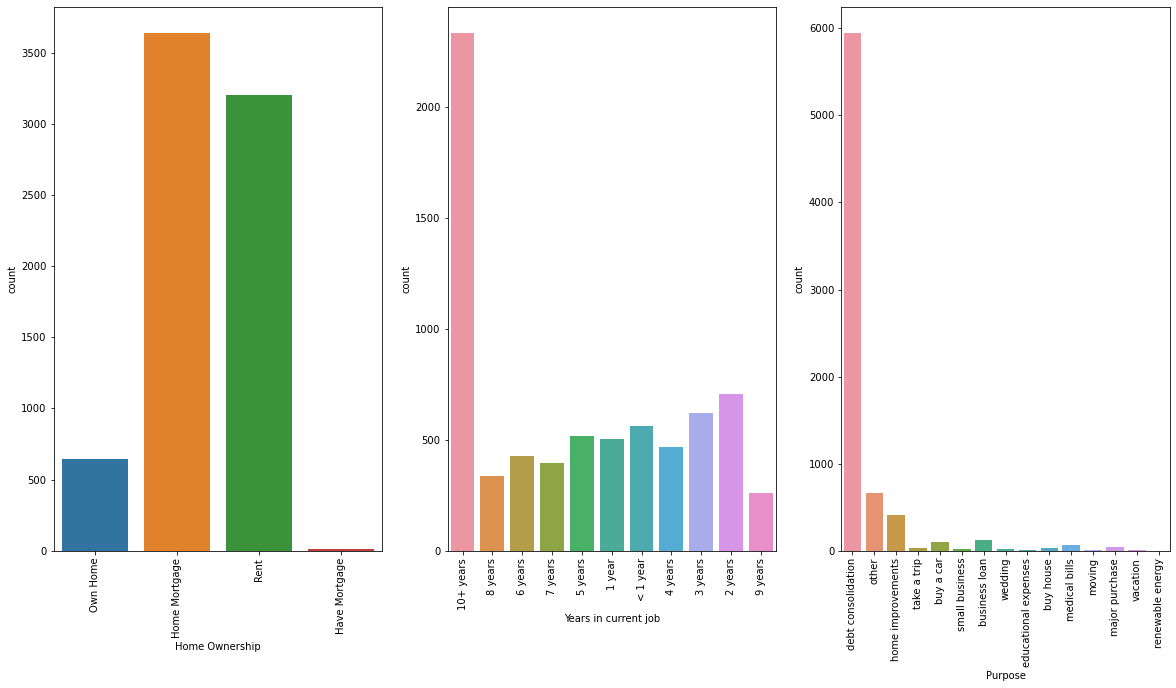

In [13]:
categorial_columns = [column for column in train_df.columns if train_df[column].dtype.name == 'object'];
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip(categorial_columns, ax.flatten()):
    sns.countplot(train_df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

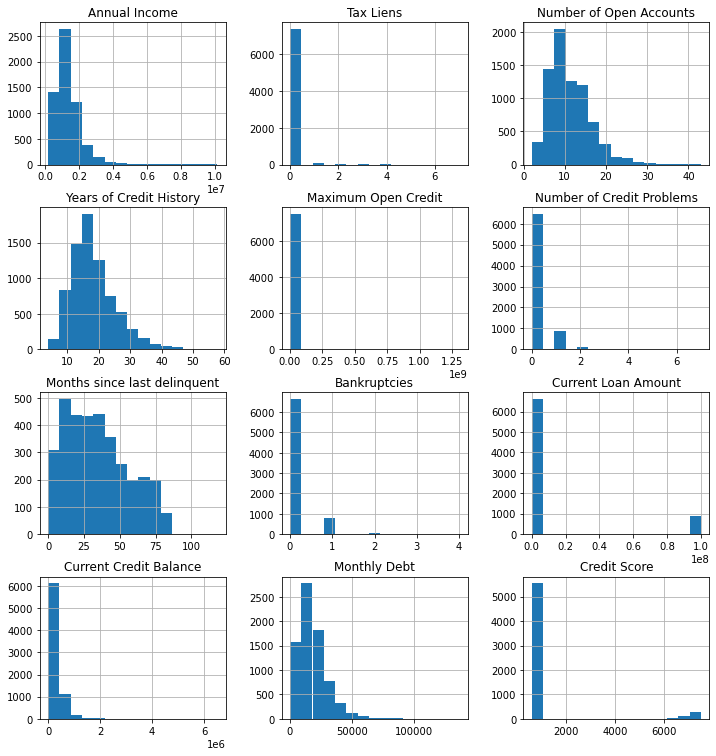

In [14]:
numerical_columns = [column for column in train_df.columns if train_df[column].dtype.name == 'float64'];
train_df[numerical_columns].hist(bins=15, figsize=(12, 40), layout=(12, 3));

### Подготовка дата фреймов

In [15]:
train_df = data_preparation(train_df)
train_df = generate_feature_engineering(train_df)

test_df = data_preparation(test_df)
test_df = generate_feature_engineering(test_df)

### Определение необходимых признаков

In [16]:
FEATURE_NAMES = [
    
    # Default columns
    'Annual Income',
    'Maximum Open Credit',
    'Months since last delinquent',
    'Credit Score',
    'Current Credit Balance',
    'Current Loan Amount',
    
    # Generated columns
    'loan_test',
    'year_credit_history',
    'ration_loan_income',
    'numeric_term',
    'monthly_income',
    'years_in_curr_job',
    'year_credit_score'

]

### Подготовка dummy-признаков

In [17]:
before_dummy_columns = train_df.columns
dummy_columns = ['Purpose']
train_df = pd.get_dummies(train_df, columns = dummy_columns)
test_df = pd.get_dummies(test_df, columns = dummy_columns)
DUMMIES_FEATURES = list(set(train_df.columns) - set(before_dummy_columns))

# Обучение модели

In [18]:
columns = FEATURE_NAMES + DUMMIES_FEATURES;
cat_boost_model = CatBoostModel(train_df, columns, TARGET)

predictions = cat_boost_model.predict(test_df[columns])

print(f'TRAIN\n{cat_boost_model.classification_report["train"]}\n')
print(f'TEST\n{cat_boost_model.classification_report["test"]}\n')
print(f'MATRIX\n{cat_boost_model.classification_report["crosstab"]}')

TRAIN
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1666
           1       0.74      0.70      0.72      1666

    accuracy                           0.73      3332
   macro avg       0.73      0.73      0.73      3332
weighted avg       0.73      0.73      0.73      3332


TEST
              precision    recall  f1-score   support

           0       0.82      0.73      0.78      1053
           1       0.50      0.63      0.56       447

    accuracy                           0.70      1500
   macro avg       0.66      0.68      0.67      1500
weighted avg       0.73      0.70      0.71      1500


MATRIX
col_0             0    1
Credit Default          
0               772  281
1               165  282


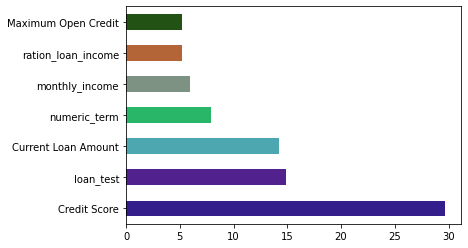

In [19]:
draw_plot_with_feature_importances(cat_boost_model.model)

In [20]:
prediction = pd.DataFrame({TARGET : predictions}).to_csv('./prediction.csv', index_label='Id', sep=',')